# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [2]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"
output_dir = "./Output"
model_dir = "./Models"
test_data_path = f"{data_dir}/Xtest.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "GRU"
model_pth_path = f"{model_dir}/best_model_{model_name}.pth"
random.seed(42)

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [4]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step(avg_val_mae_loss)

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Gated recurrent units (GRUs) RNN Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.dropout= nn.Dropout(dropout) if num_stacked_layers > 1 else 0.0

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


### Load and Split the dataset into train-validation

In [6]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

# load the test data
test_data = loadmat(test_data_path)
test_measurements = test_data['Xtest']
print("Shape of test measurements:", test_measurements.shape)
print(f"test_measurements range: min={test_measurements.min()}, max={test_measurements.max()}")
test_data_normalized = scaler.transform(test_measurements)
print(f"test_data_normalized range: min={test_data_normalized.min()}, max={test_data_normalized.max()}")
test_dataset = test_data_normalized


Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=0.03952569169960474, max=0.6996047430830039
Shape of test measurements: (200, 1)
test_measurements range: min=3, max=255
test_data_normalized range: min=0.003952569169960474, max=1.0


### Training the Model 

In [ ]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 128, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 7, 20, step=1)
    # dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.1) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = GRU(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size,
        num_stacked_layers=num_layers,
        # dropout=dropout
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    # metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                # "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"{output_dir}/all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = GRU(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers'],
    # dropout = study.best_params['dropout']
).to(device)
best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-08 00:54:01,321] A new study created in memory with name: no-name-395f06dd-be6f-4db2-a260-c93fcc59f511


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_7900\3583922667.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-08 00:54:35,514] Trial 0 finished with value: 0.012537387781776488 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 8.548567160149543e-05, 'batch_size': 32, 'window_size': 11}. Best is trial 0 with value: 0.012537387781776488.


Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:54:47,583] Trial 1 finished with value: 0.11742332577705383 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 2.8972043274448047e-05, 'batch_size': 128, 'window_size': 19}. Best is trial 0 with value: 0.012537387781776488.


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:54:59,296] Trial 2 finished with value: 0.00470730900997296 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.006978242199383046, 'batch_size': 64, 'window_size': 8}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 70 epochs.
Best model saved with trial 2


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:55:26,685] Trial 3 finished with value: 0.005442372697871178 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.00032625598647143206, 'batch_size': 32, 'window_size': 12}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 85 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:55:37,229] Trial 4 finished with value: 0.006765985861420631 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0003197529079239438, 'batch_size': 128, 'window_size': 19}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 94 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:56:09,991] Trial 5 finished with value: 0.06931668845936656 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 1.0933453691167712e-05, 'batch_size': 32, 'window_size': 14}. Best is trial 2 with value: 0.00470730900997296.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:56:20,232] Trial 6 finished with value: 0.004998230957426131 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009322909375543748, 'batch_size': 64, 'window_size': 12}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 61 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:56:29,548] Trial 7 finished with value: 0.017673376947641373 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.000238450547252265, 'batch_size': 128, 'window_size': 13}. Best is trial 2 with value: 0.00470730900997296.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:56:59,245] Trial 8 finished with value: 0.010183077480178326 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0003404296324399838, 'batch_size': 32, 'window_size': 19}. Best is trial 2 with value: 0.00470730900997296.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:57:09,288] Trial 9 finished with value: 0.007417362299747765 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0006755136194896198, 'batch_size': 64, 'window_size': 8}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 53 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:57:20,244] Trial 10 finished with value: 0.006514965207315981 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.00622781153167548, 'batch_size': 64, 'window_size': 7}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 57 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:57:27,261] Trial 11 finished with value: 0.006561110261827707 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009757717927078344, 'batch_size': 64, 'window_size': 10}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 44 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:57:43,636] Trial 12 finished with value: 0.00515641231322661 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0026216398054970573, 'batch_size': 64, 'window_size': 16}. Best is trial 2 with value: 0.00470730900997296.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:57:51,858] Trial 13 finished with value: 0.005329018225893378 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0023115745672558927, 'batch_size': 64, 'window_size': 10}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 45 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:58:01,295] Trial 14 finished with value: 0.005094538908451796 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0024358710366323565, 'batch_size': 64, 'window_size': 15}. Best is trial 2 with value: 0.00470730900997296.


Early stopping triggered after 59 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:58:10,794] Trial 15 finished with value: 0.004111950926017016 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00442969458376559, 'batch_size': 64, 'window_size': 9}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 54 epochs.
Best model saved with trial 15


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:58:14,658] Trial 16 finished with value: 0.017885285895317793 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.003128490346425737, 'batch_size': 64, 'window_size': 8}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 21 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:58:32,783] Trial 17 finished with value: 0.004125022562220693 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0012270554141010778, 'batch_size': 64, 'window_size': 9}. Best is trial 15 with value: 0.004111950926017016.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:58:51,213] Trial 18 finished with value: 0.00472447625361383 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0013012559194229994, 'batch_size': 64, 'window_size': 10}. Best is trial 15 with value: 0.004111950926017016.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:59:04,624] Trial 19 finished with value: 0.004356902441941202 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0009342075883084736, 'batch_size': 128, 'window_size': 17}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 99 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:59:25,144] Trial 20 finished with value: 0.020499059930443764 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.00011342141566042273, 'batch_size': 64, 'window_size': 7}. Best is trial 15 with value: 0.004111950926017016.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:59:33,068] Trial 21 finished with value: 0.0046457883436232805 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0007728248293421339, 'batch_size': 128, 'window_size': 16}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 60 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:59:41,649] Trial 22 finished with value: 0.004464202560484409 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.001125465621074602, 'batch_size': 128, 'window_size': 16}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 65 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:59:47,935] Trial 23 finished with value: 0.005444616312161088 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.004062586931380204, 'batch_size': 128, 'window_size': 17}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 54 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 00:59:52,132] Trial 24 finished with value: 0.007380008464679122 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0013635174142048324, 'batch_size': 128, 'window_size': 9}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 38 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:00:00,101] Trial 25 finished with value: 0.00452044140547514 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.000689279065074521, 'batch_size': 128, 'window_size': 20}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 71 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:00:13,277] Trial 26 finished with value: 0.0043731757323257625 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.004737910917378387, 'batch_size': 64, 'window_size': 13}. Best is trial 15 with value: 0.004111950926017016.


Early stopping triggered after 69 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:00:34,993] Trial 27 finished with value: 0.003662837960291654 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.002070246250126023, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Best model saved with trial 27


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:00:59,581] Trial 28 finished with value: 0.0038186372257769108 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0015597983686121842, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:01:12,261] Trial 29 finished with value: 0.015330824418924749 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.002049813854027125, 'batch_size': 32, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 33 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:01:29,134] Trial 30 finished with value: 0.008413744857534766 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.00015400053437207424, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 76 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:01:53,674] Trial 31 finished with value: 0.004030572657939047 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0014795950965868006, 'batch_size': 64, 'window_size': 9}. Best is trial 27 with value: 0.003662837960291654.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:01:59,311] Trial 32 finished with value: 0.023904109373688698 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0017258080022449368, 'batch_size': 64, 'window_size': 9}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 23 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:02:15,306] Trial 33 finished with value: 0.005959015688858926 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.00048783659217672986, 'batch_size': 64, 'window_size': 12}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 63 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:02:39,630] Trial 34 finished with value: 0.028324200306087732 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 5.0109873127708105e-05, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:02:49,693] Trial 35 finished with value: 0.010738165467046201 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.004651732766356659, 'batch_size': 64, 'window_size': 10}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 41 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:03:10,219] Trial 36 finished with value: 0.00676915148505941 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.006396808474461174, 'batch_size': 32, 'window_size': 12}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 53 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:03:31,427] Trial 37 finished with value: 0.0040744484285824 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.003444125055804098, 'batch_size': 64, 'window_size': 9}. Best is trial 27 with value: 0.003662837960291654.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:03:45,502] Trial 38 finished with value: 0.004832524107769132 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0033304224561182248, 'batch_size': 64, 'window_size': 8}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 64 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:04:04,200] Trial 39 finished with value: 0.004963482380844653 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0004966424924185712, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 73 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:04:12,766] Trial 40 finished with value: 0.014457096171099693 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.0017796726979184031, 'batch_size': 32, 'window_size': 12}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 22 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:04:22,812] Trial 41 finished with value: 0.0067241977667436 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0035329766235735727, 'batch_size': 64, 'window_size': 9}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 47 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:04:47,347] Trial 42 finished with value: 0.0037794827367179096 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.005312143582999115, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:04:53,086] Trial 43 finished with value: 0.012794031063094735 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.006899474523089197, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 23 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:05:18,069] Trial 44 finished with value: 0.10222930274903774 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 1.3319198592482281e-05, 'batch_size': 64, 'window_size': 13}. Best is trial 27 with value: 0.003662837960291654.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:05:41,865] Trial 45 finished with value: 0.003705643815919757 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.001684104071892961, 'batch_size': 64, 'window_size': 10}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 98 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:06:06,286] Trial 46 finished with value: 0.007238591089844704 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.00047166315245804373, 'batch_size': 64, 'window_size': 10}. Best is trial 27 with value: 0.003662837960291654.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:06:31,293] Trial 47 finished with value: 0.004108253284357488 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.0016226528960877167, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:06:38,032] Trial 48 finished with value: 0.02796145947650075 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.0010053667113606075, 'batch_size': 32, 'window_size': 7}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 18 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:06:42,737] Trial 49 finished with value: 0.03020821511745453 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.00880137783722038, 'batch_size': 64, 'window_size': 12}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 21 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:07:00,684] Trial 50 finished with value: 0.008422957500442863 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.00020368350829156793, 'batch_size': 64, 'window_size': 10}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 78 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:07:25,170] Trial 51 finished with value: 0.004384522908367217 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.002655086161099865, 'batch_size': 64, 'window_size': 10}. Best is trial 27 with value: 0.003662837960291654.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:07:32,801] Trial 52 finished with value: 0.005856246221810579 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.002680274695693294, 'batch_size': 64, 'window_size': 9}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 31 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:07:42,668] Trial 53 finished with value: 0.011074060807004571 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.00565081241230876, 'batch_size': 64, 'window_size': 8}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 41 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:07:59,642] Trial 54 finished with value: 0.004290689947083592 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0020053734128630987, 'batch_size': 64, 'window_size': 13}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 67 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:08:08,046] Trial 55 finished with value: 0.011380634736269712 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0031587663690527523, 'batch_size': 64, 'window_size': 8}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 35 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:08:32,579] Trial 56 finished with value: 0.006132131326012313 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0008037182971077252, 'batch_size': 64, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:08:43,664] Trial 57 finished with value: 0.0069771172711625695 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.001468403382673309, 'batch_size': 64, 'window_size': 9}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 45 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:09:05,520] Trial 58 finished with value: 0.004366135806776583 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.005097657487555136, 'batch_size': 64, 'window_size': 10}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 89 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:09:30,930] Trial 59 finished with value: 0.004018228850327432 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0023580514867808625, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:09:54,325] Trial 60 finished with value: 0.003994355560280383 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0010555131051358402, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 90 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:10:03,705] Trial 61 finished with value: 0.012068493408150971 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0009916615677618176, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 35 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:10:09,020] Trial 62 finished with value: 0.01689806254580617 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.002327253375553376, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 20 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:10:34,674] Trial 63 finished with value: 0.005534080788493156 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0006046676180928001, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:11:00,204] Trial 64 finished with value: 0.0038488786085508764 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0013590750132406529, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:11:26,283] Trial 65 finished with value: 0.004271703655831516 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0011314920831156958, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:12:01,094] Trial 66 finished with value: 0.006293479993473738 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.00038088134717009087, 'batch_size': 32, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:12:11,930] Trial 67 finished with value: 0.004227470373734832 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0020585655028388526, 'batch_size': 128, 'window_size': 17}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 57 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:12:24,946] Trial 68 finished with value: 0.005322043667547405 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0008290580471045245, 'batch_size': 64, 'window_size': 13}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 65 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:12:36,830] Trial 69 finished with value: 0.00579133362043649 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0013114592706129275, 'batch_size': 64, 'window_size': 16}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 45 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:12:41,608] Trial 70 finished with value: 0.015941281337291002 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.002636765769790727, 'batch_size': 64, 'window_size': 12}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 19 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:13:08,519] Trial 71 finished with value: 0.0047428083489649 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0014926948607823997, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:13:19,315] Trial 72 finished with value: 0.008082295302301645 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0019185149316444574, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 41 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:13:45,717] Trial 73 finished with value: 0.003980212088208646 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0011659578643950282, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:14:00,209] Trial 74 finished with value: 0.0038071631570346653 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0006344051171446924, 'batch_size': 64, 'window_size': 16}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 54 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:14:08,511] Trial 75 finished with value: 0.006860495079308748 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0006147644288480335, 'batch_size': 64, 'window_size': 18}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 41 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:14:22,171] Trial 76 finished with value: 0.005002035992220044 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0011302866877588621, 'batch_size': 64, 'window_size': 16}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 53 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:14:32,055] Trial 77 finished with value: 0.009543066378682852 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0003824130057618371, 'batch_size': 128, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:14:38,824] Trial 78 finished with value: 0.0075205202447250485 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0008820651851716767, 'batch_size': 64, 'window_size': 16}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 34 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:14:48,997] Trial 79 finished with value: 0.011995401582680643 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0002823962414066771, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 52 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:15:00,319] Trial 80 finished with value: 0.005203862325288355 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0006802039471962404, 'batch_size': 64, 'window_size': 18}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 43 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:15:09,437] Trial 81 finished with value: 0.013600008329376578 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.003794887465132782, 'batch_size': 64, 'window_size': 15}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 35 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:15:35,226] Trial 82 finished with value: 0.004773757653310895 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0012924166062092011, 'batch_size': 64, 'window_size': 14}. Best is trial 27 with value: 0.003662837960291654.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:15:46,355] Trial 83 finished with value: 0.007084111915901303 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0018112804996043082, 'batch_size': 64, 'window_size': 13}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 42 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:15:55,379] Trial 84 finished with value: 0.01536786777433008 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0010553018918805026, 'batch_size': 32, 'window_size': 11}. Best is trial 27 with value: 0.003662837960291654.


Early stopping triggered after 24 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:16:21,184] Trial 85 finished with value: 0.0035715976264327765 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0023254140747260106, 'batch_size': 64, 'window_size': 15}. Best is trial 85 with value: 0.0035715976264327765.


Best model saved with trial 85


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:16:30,194] Trial 86 finished with value: 0.007520775543525815 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0015506821053956508, 'batch_size': 64, 'window_size': 16}. Best is trial 85 with value: 0.0035715976264327765.


Early stopping triggered after 34 epochs.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:16:56,365] Trial 87 finished with value: 0.004009923548437655 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0005368050402058939, 'batch_size': 64, 'window_size': 17}. Best is trial 85 with value: 0.0035715976264327765.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:17:16,719] Trial 88 finished with value: 0.004739144584164023 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.008949033913458578, 'batch_size': 64, 'window_size': 15}. Best is trial 85 with value: 0.0035715976264327765.


Early stopping triggered after 77 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:17:42,143] Trial 89 finished with value: 0.005538496887311339 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0007332476363864312, 'batch_size': 64, 'window_size': 12}. Best is trial 85 with value: 0.0035715976264327765.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:17:58,011] Trial 90 finished with value: 0.003108177101239562 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0030283307759965735, 'batch_size': 128, 'window_size': 16}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 84 epochs.
Best model saved with trial 90


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:03,198] Trial 91 finished with value: 0.012150302063673735 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.002939766343207907, 'batch_size': 128, 'window_size': 16}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 27 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:22,087] Trial 92 finished with value: 0.0033501068828627467 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.004298438304348008, 'batch_size': 128, 'window_size': 16}. Best is trial 90 with value: 0.003108177101239562.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:28,469] Trial 93 finished with value: 0.006322287488728762 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.004637041050284548, 'batch_size': 128, 'window_size': 17}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 32 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:34,069] Trial 94 finished with value: 0.009911960922181606 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0038791143886716685, 'batch_size': 128, 'window_size': 18}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 27 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:39,091] Trial 95 finished with value: 0.011801467277109623 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0030003694284204065, 'batch_size': 128, 'window_size': 16}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 26 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:46,042] Trial 96 finished with value: 0.006535155698657036 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0076248349710653, 'batch_size': 128, 'window_size': 17}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 45 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:18:53,817] Trial 97 finished with value: 0.004549235105514526 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.005201964857913425, 'batch_size': 128, 'window_size': 11}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 54 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:19:08,101] Trial 98 finished with value: 0.0038051693700253963 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0021203206170458907, 'batch_size': 128, 'window_size': 10}. Best is trial 90 with value: 0.003108177101239562.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:19:14,392] Trial 99 finished with value: 0.004701878177002072 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.005623457093672282, 'batch_size': 128, 'window_size': 10}. Best is trial 90 with value: 0.003108177101239562.


Early stopping triggered after 44 epochs.
All metrics saved to ./Output/all_trials_metrics_GRU.csv
Best hyperparameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0030283307759965735, 'batch_size': 128, 'window_size': 16}
Best validation loss: 0.003108177101239562
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_7900\3583922667.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


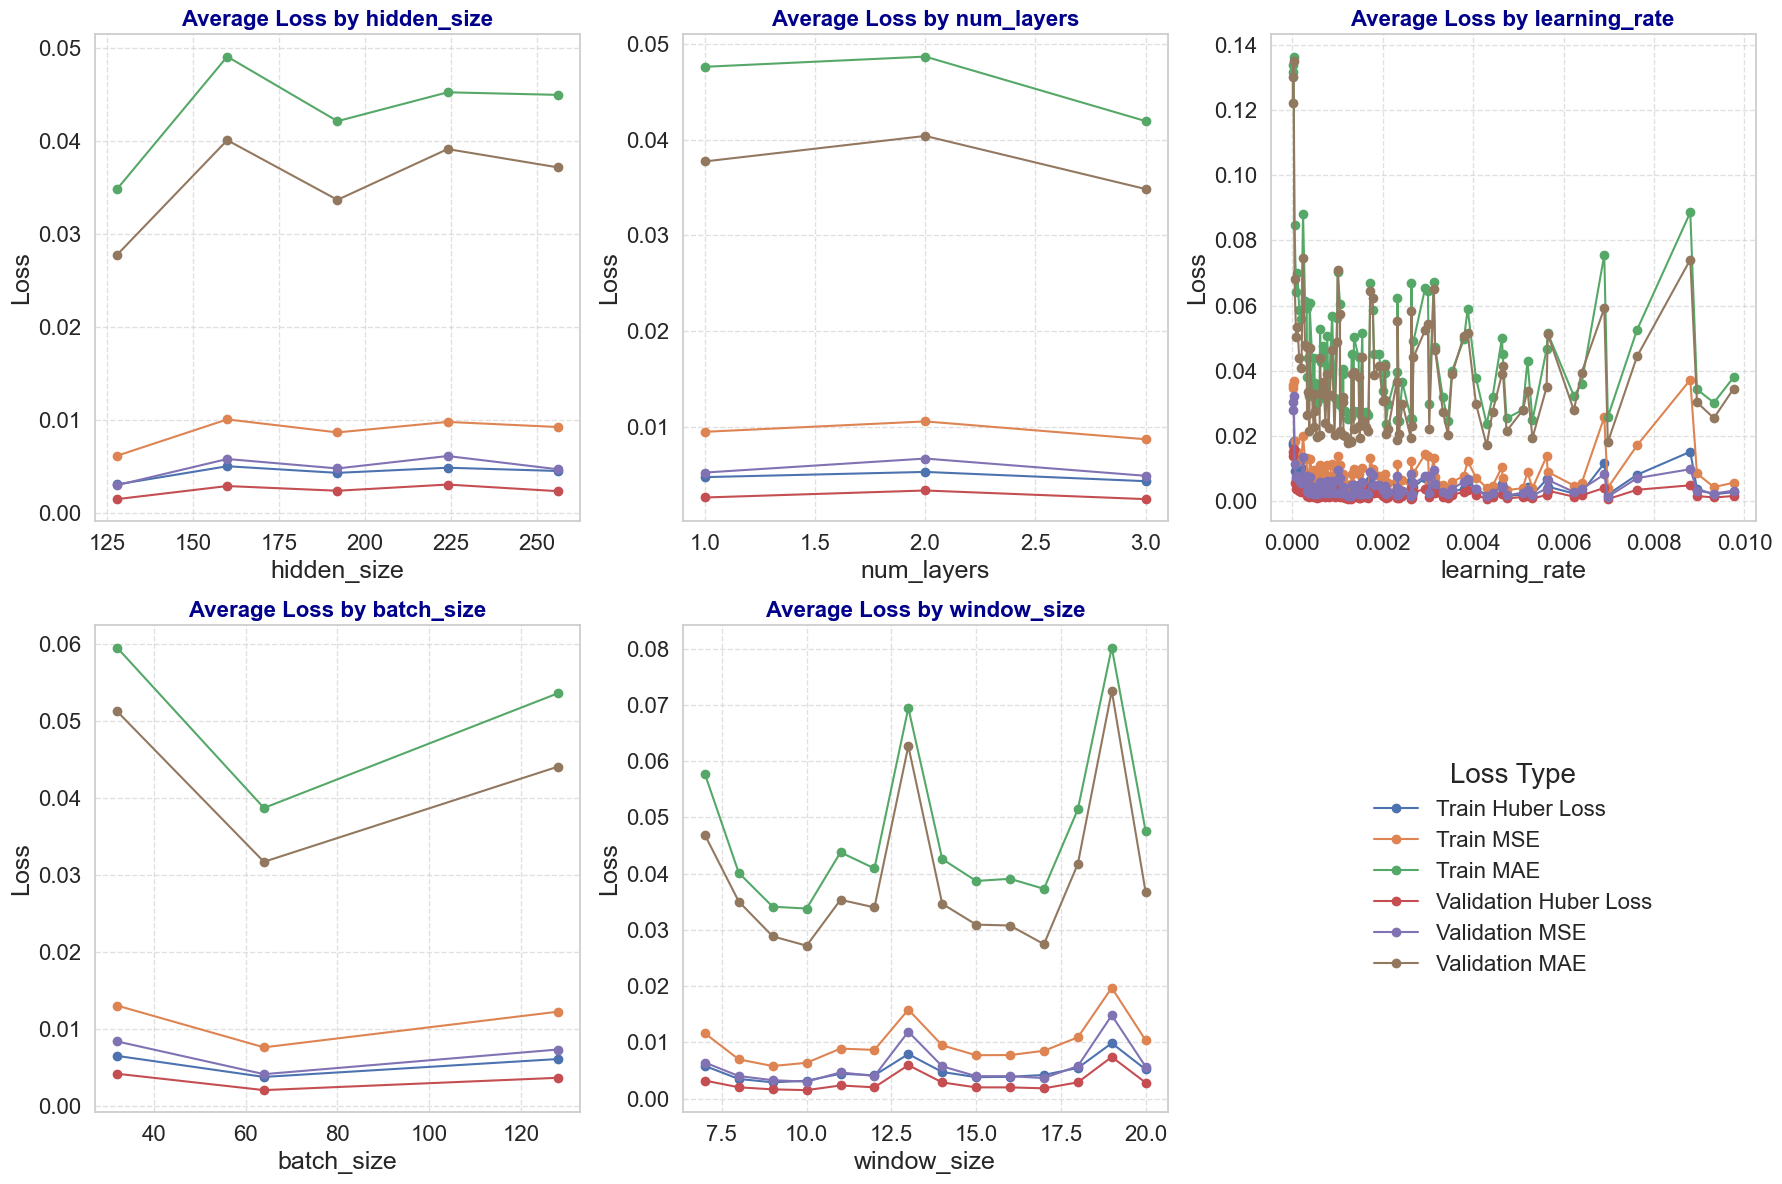

In [8]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"{output_dir}/metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_46352\410383499.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


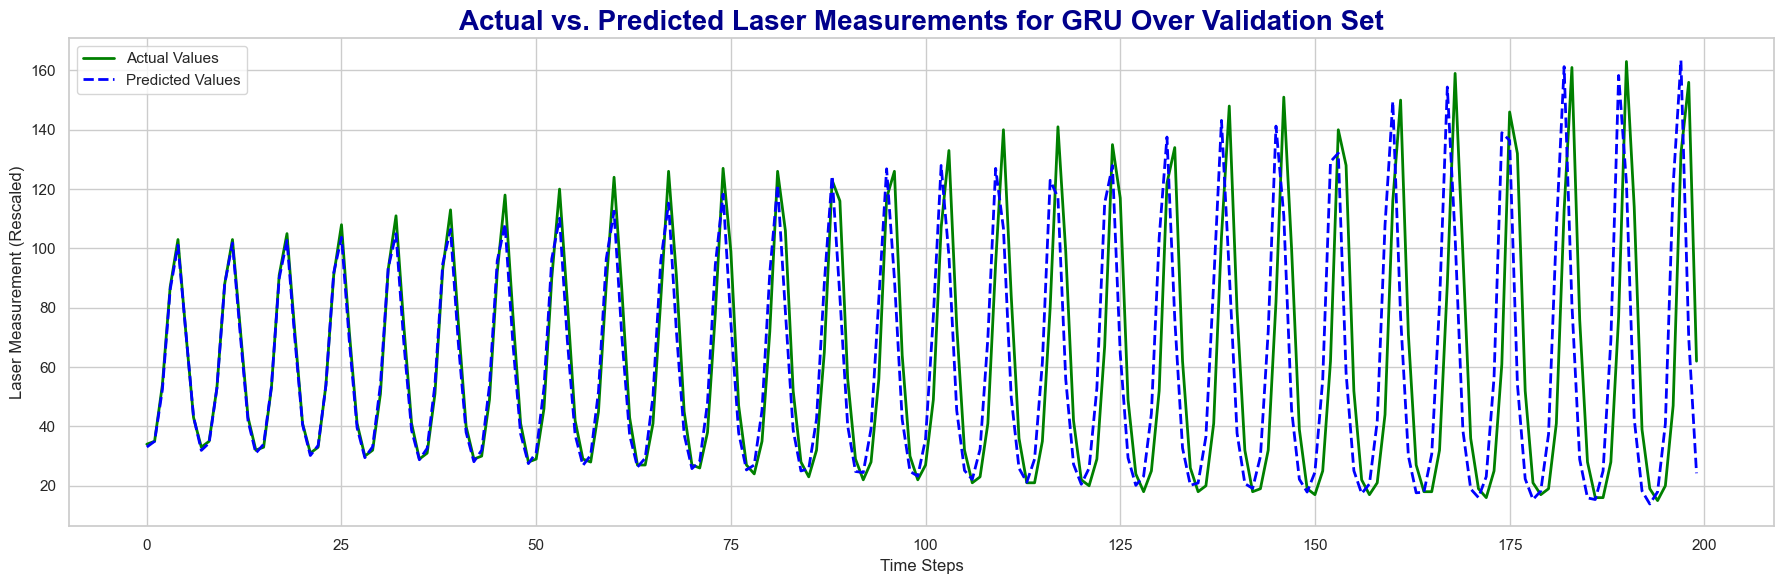

Metrics plot saved to ./Output/actual_vs_predicted_plot_GRU_val.png


In [16]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained Gated recurrent units (GRUs) model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path, daateset_name=""):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title(f"Actual vs. Predicted Laser Measurements for {model_name} Over {daateset_name}", fontsize=20, weight='bold', color='darkblue')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_val.png", "Validation Set")

### Load the trained model

In [9]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = GRU(
        input_size=1,
        hidden_size=best_params['hidden_size'],
        num_stacked_layers=best_params['num_layers'],
        # dropout = best_params['dropout']
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

# Update data loaders with the suggested batch size
window_size = best_params['window_size']
batch_size = best_params['batch_size']
train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)
test_loader, test_X, test_y = prepare_dataloader(test_dataset, window_size, batch_size=batch_size)

Best hyperparameters are: {'hidden_size': 192, 'num_layers': 3, 'learning_rate': 0.0030283307759965735, 'batch_size': 128, 'window_size': 16}


C:\Users\bar24\AppData\Local\Temp\ipykernel_46352\958826985.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


## Evaluate the model

In [20]:
import torch.nn as nn

def evaluate_model(best_model, val_loader, dataset_name, scaler):
    """
    Evaluate the best model on given dataset and calculate MSE and MAE in the unnormalized scale.

    Args:
        best_model: The trained model.
        val_loader: The given dataset (normalized).
        dataset_name: Name of the dataset (e.g., "Training", "Validation", "Test").
        scaler: The MinMaxScaler used for normalization.

    Returns:
        mse: Mean Squared Error (unnormalized).
        mae: Mean Absolute Error (unnormalized).
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Inverse transform predictions and ground truth to the original scale
            output_unnormalized = scaler.inverse_transform(output.cpu().numpy())
            y_batch_unnormalized = scaler.inverse_transform(y_batch.cpu().numpy())

            # Convert back to tensors for loss calculation
            output_unnormalized = torch.tensor(output_unnormalized, dtype=torch.float32)
            y_batch_unnormalized = torch.tensor(y_batch_unnormalized, dtype=torch.float32)

            # Calculate losses
            mse = mse_criterion(output_unnormalized, y_batch_unnormalized).item()
            mae = mae_criterion(output_unnormalized, y_batch_unnormalized).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"For model: {model_name} - {dataset_name} Evaluation:")
    print(f"{dataset_name} MSE (unnormalized): {avg_mse}")
    print(f"{dataset_name} MAE (unnormalized): {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model(best_model, train_loader, "Training", scaler)
mse, mae = evaluate_model(best_model, val_loader, "Validation", scaler)
mse, mae = evaluate_model(best_model, test_loader, "Test", scaler)

For model: GRU - Training Evaluation:
Training MSE (unnormalized): 89.33657570528399
Training MAE (unnormalized): 2.492745870303068
For model: GRU - Validation Evaluation:
Validation MSE (unnormalized): 1.1230437938983624
Validation MAE (unnormalized): 0.8272284559714489
For model: GRU - Test Evaluation:
Test MSE (unnormalized): 146.33751936580825
Test MAE (unnormalized): 3.751625491225201


C:\Users\bar24\AppData\Local\Temp\ipykernel_46352\241660653.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(test_X[0], dtype=torch.float32).to(device)


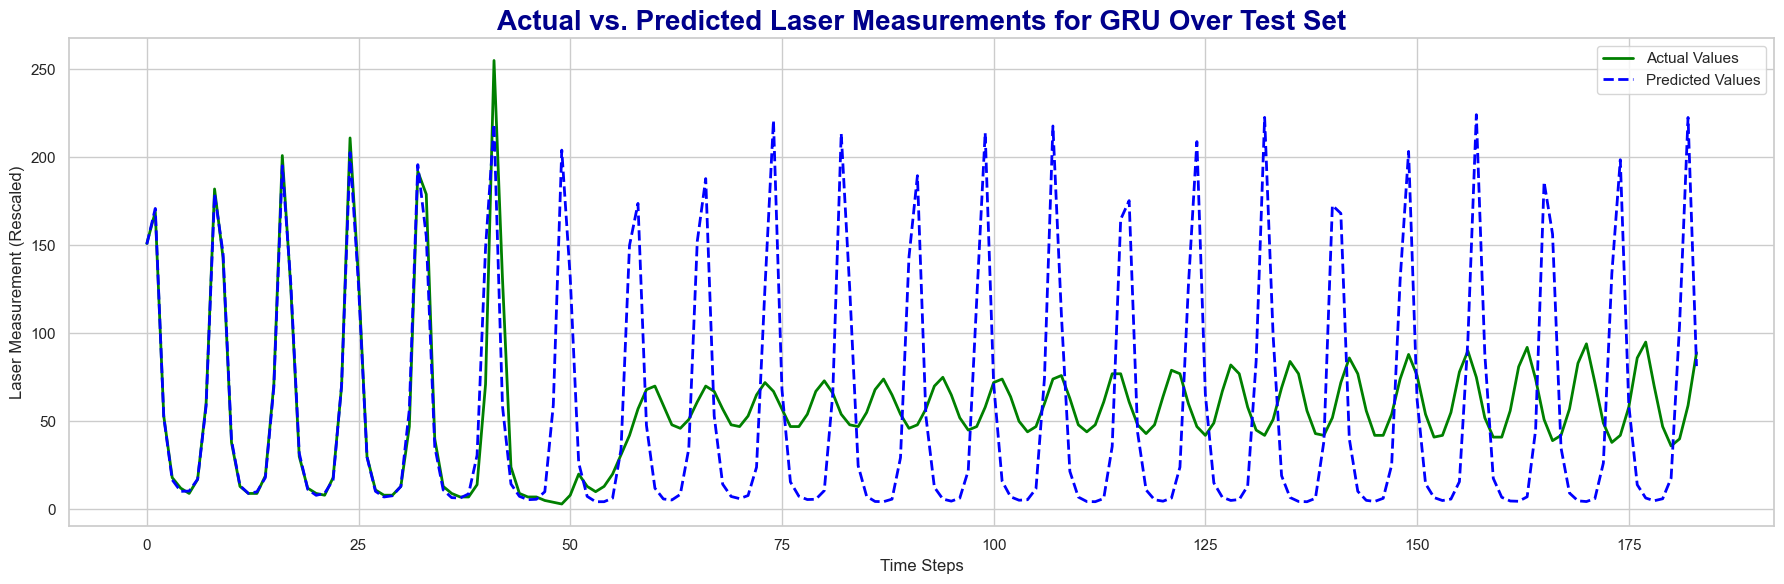

Metrics plot saved to ./Output/actual_vs_predicted_plot_GRU_test.png


In [19]:
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(test_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
steps = 200 - window_size
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=steps)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(test_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_test.png", "Test Set")

## Plot for results

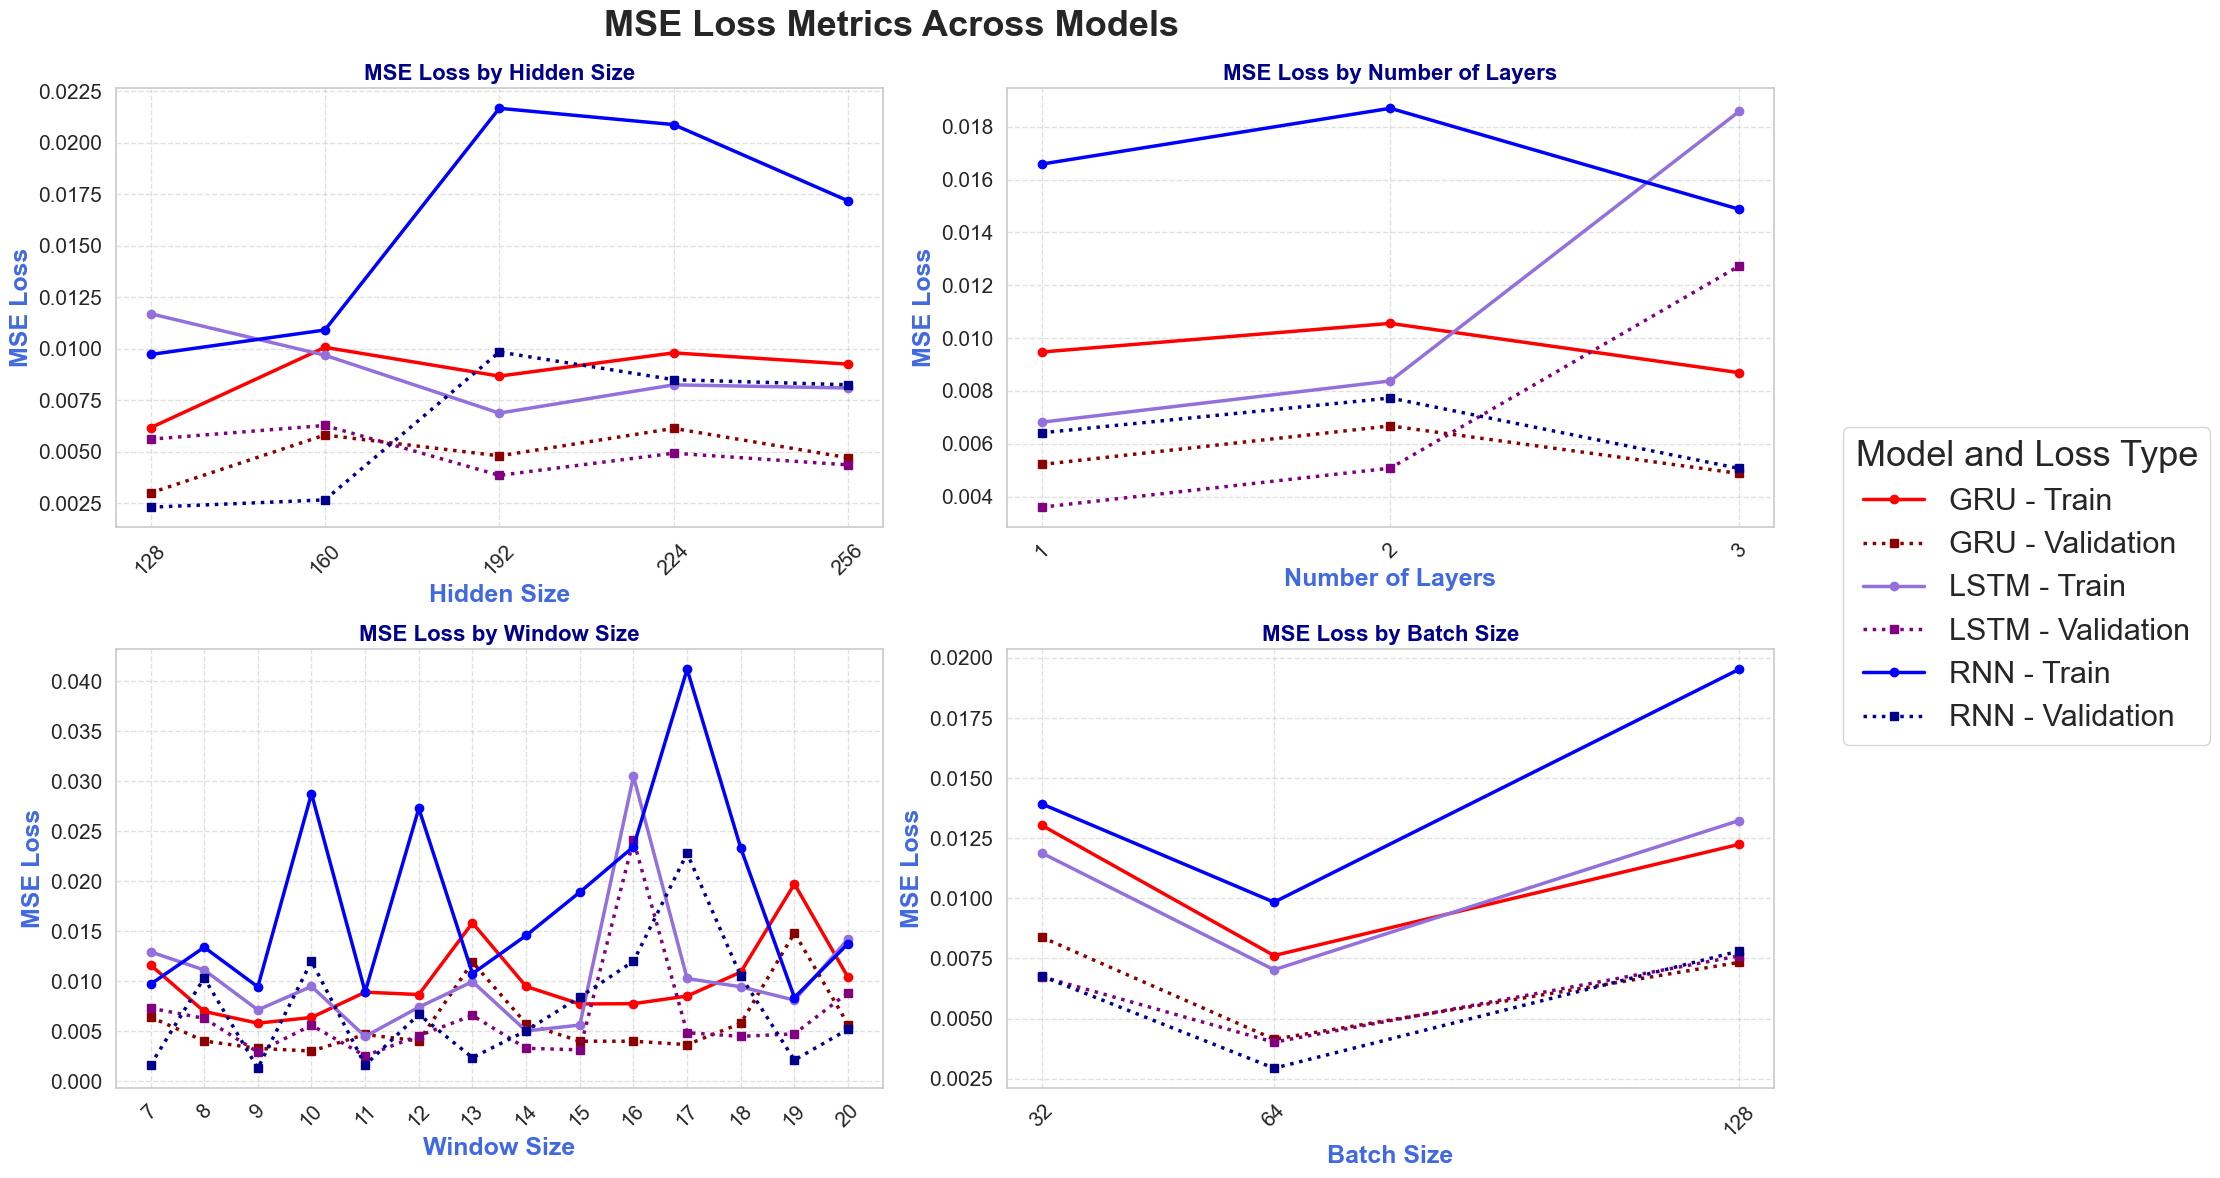

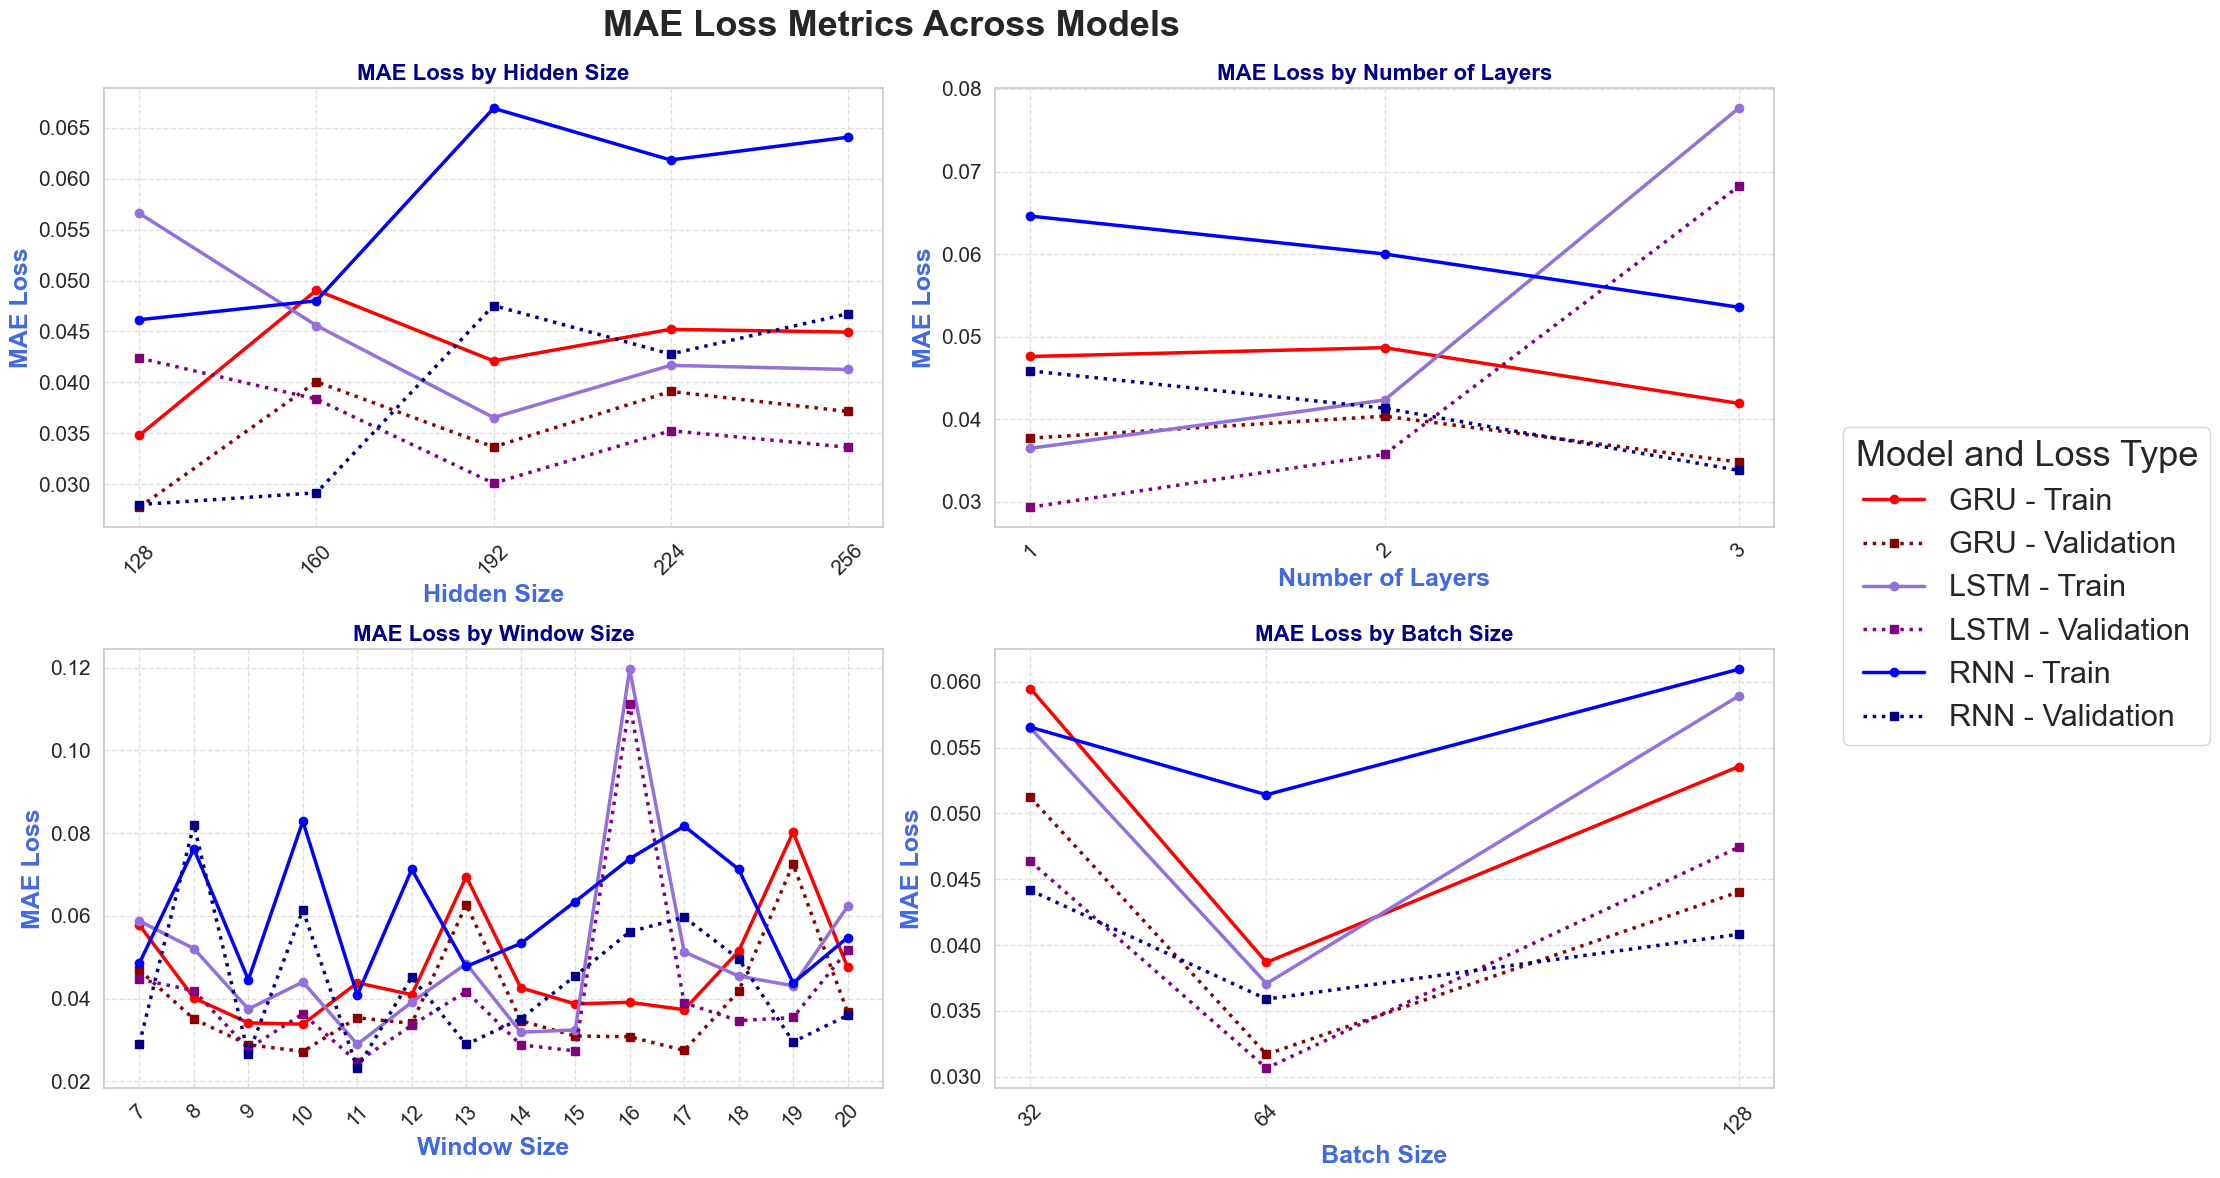

In [76]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files for RNN, LSTM, and GRU
rnn_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_RNN.csv")
lstm_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_LSTM.csv")
gru_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_GRU.csv")

# Add a column to identify the model
rnn_metrics["model"] = "RNN"
lstm_metrics["model"] = "LSTM"
gru_metrics["model"] = "GRU"

# Combine all metrics into a single DataFrame
all_metrics = pd.concat([rnn_metrics, lstm_metrics, gru_metrics], ignore_index=True)

# Define the parameters to plot
parameters_to_plot = ["hidden_size", "num_layers", "window_size", "batch_size"]

# Ensure all columns in parameters_to_plot are numeric and drop rows with NaN values
for param in parameters_to_plot:
    if param in all_metrics.columns:
        all_metrics[param] = pd.to_numeric(all_metrics[param], errors="coerce")
all_metrics = all_metrics.dropna(subset=parameters_to_plot)

# Define the loss functions to plot
loss_functions = {
    "MSE": ["train_MSE", "val_MSE"],
    "MAE": ["train_MAE", "val_MAE"]
}

# Define a mapping for paper-friendly parameter names
parameter_name_mapping = {
    "hidden_size": "Hidden Size",
    "num_layers": "Number of Layers",
    "window_size": "Window Size",
    "batch_size": "Batch Size"
}

# Replace parameter names in the parameters_to_plot list
parameters_to_plot = [parameter_name_mapping[param] for param in parameters_to_plot]

# Define colors for models
model_colors = {
    "RNN": ("blue", "darkblue"),
    "LSTM": ("mediumpurple", "purple"),
    "GRU": ("red", "darkred")
}

# Function to plot metrics for each loss function
# Function to plot metrics for each loss function
def plot_loss_metrics(metrics_df, loss_type, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses for train and validation.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        loss_type (str): The loss type to plot (e.g., "MSE", "MAE").
        parameters (list): List of parameters to plot (e.g., ['Hidden Size', 'Number of Layers', 'Window Size', 'Batch Size']).
        save_path (str): Path to save the plot.
    """
    loss_columns = loss_functions[loss_type]
    num_params = len(parameters)
    ncols = 2  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Define markers for train and validation sets
    markers = {"train": "o", "val": "s"}  # Circle for train, square for validation
    linestyles = {"train": "-", "val": ":"}  # Solid for train, dotted for validation

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        original_param = [key for key, value in parameter_name_mapping.items() if value == parameter][0]
        if original_param not in metrics_df.columns:
            continue  # Skip if the parameter is not in the DataFrame
        for model_name, model_df in metrics_df.groupby("model"):
            # Ensure the parameter column is numeric
            model_df[original_param] = pd.to_numeric(model_df[original_param], errors="coerce")
            model_df = model_df.dropna(subset=[original_param])  # Drop rows with NaN in the parameter column
            
            grouped = model_df.groupby(original_param).mean(numeric_only=True)  # Group by the parameter and calculate averages
            for loss_col, color in zip(loss_columns, model_colors[model_name]):
                if loss_col in grouped.columns:
                    # Determine marker type based on whether it's train or validation
                    marker_type = markers["train"] if "train" in loss_col else markers["val"]
                    linestyle_type = linestyles["train"] if "train" in loss_col else linestyles["val"]

                    label = f"{model_name} - {'Train' if 'train' in loss_col else 'Validation'}"
                    ax.plot(grouped.index, grouped[loss_col], label=label, color=color, marker=marker_type, linestyle=linestyle_type, linewidth=2.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18, color='royalblue', weight='bold')
        ax.set_ylabel(f"{loss_type} Loss", fontsize=18, color='royalblue', weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f"{loss_type} Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

        # Set x-axis ticks to the unique values of the parameter
        unique_values = sorted(metrics_df[original_param].unique())
        ax.set_xticks(unique_values)
        ax.set_xticklabels([str(int(val)) if val.is_integer() else f"{val:.2f}" for val in unique_values], rotation=45)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Add a legend to the right of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=22, title="Model and Loss Type", title_fontsize=26)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
    plt.suptitle(f"{loss_type} Loss Metrics Across Models", fontsize=26, weight='bold')
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Generate plots for MSE and MAE
plot_loss_metrics(all_metrics, "MSE", parameters_to_plot, f"{output_dir}/MSE_loss_metrics_across_models.png")
plot_loss_metrics(all_metrics, "MAE", parameters_to_plot, f"{output_dir}/MAE_loss_metrics_across_models.png")